In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm import tqdm

device = 'cuda'

In [2]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda t: (t * 2) - 1),
])

train_dataset = torchvision.datasets.ImageFolder(
    root='flowers/train',
    transform=data_transform
)

val_dataset = torchvision.datasets.ImageFolder(
    root='flowers/valid',
    transform=data_transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    #num_workers=1,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    #num_workers=1,
    shuffle=True
)

mean: -0.28096196
variance: 0.3180972


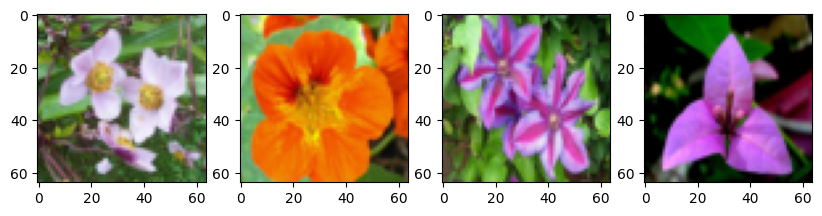

In [5]:
images = next(iter(train_loader))
images = images[0]
images = images.numpy()

print('mean:', images.mean())
print('variance:', images.var())

fig, axes = plt.subplots(figsize=(10, 4), ncols=4)
for i in range(4):
    ax = axes[i]
    ax.imshow(np.transpose((images[i] + 1) / 2, (1, 2, 0)))
plt.show()

In [6]:
def linear_diffusion_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

def add_noise(x0, t, noise, sqrt_alphas_bar, sqrt_one_minus_alphas_bar):
    batch_size = x0.shape[0]

    sqrt_alphas_bar_t = sqrt_alphas_bar.gather(-1, t).reshape(batch_size, 1, 1, 1)
    sqrt_one_minus_alphas_bar_t = sqrt_one_minus_alphas_bar.gather(-1, t).reshape(batch_size, 1, 1, 1)

    return sqrt_alphas_bar_t * x0 + sqrt_one_minus_alphas_bar_t * noise

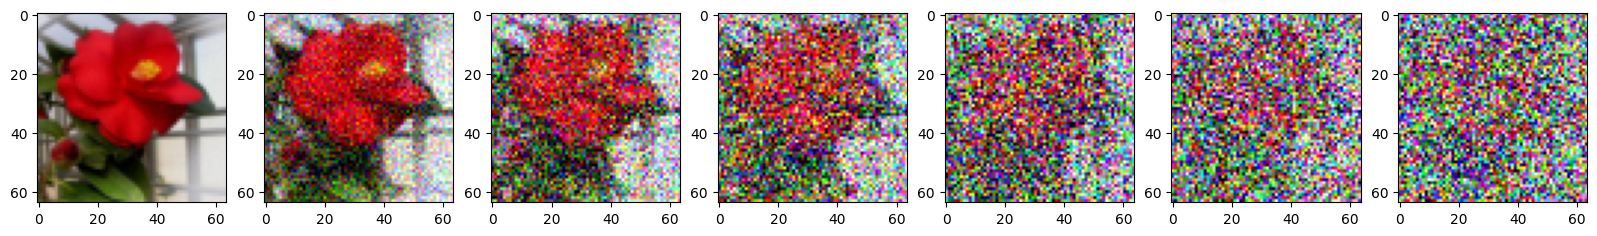

In [7]:
images = next(iter(train_loader))[0]
image = images[0].float()

T = 300

betas = linear_diffusion_schedule(timesteps=T)

alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, axis=0)

sqrt_alphas_bar= torch.sqrt(alphas_bar)
sqrt_one_minus_alphas_bar = torch.sqrt(1.0 - alphas_bar)

num_steps = 7
image_batch = image.unsqueeze(0).expand(num_steps, -1, -1, -1)
noise = torch.randn_like(image_batch)
timesteps = torch.linspace(0, T - 1, num_steps).round().long()

noisy_images = add_noise(image_batch, timesteps, noise, sqrt_alphas_bar, sqrt_one_minus_alphas_bar)

fig, axes = plt.subplots(figsize=(20, 20), ncols=num_steps)

for i in range(num_steps):
    ax = axes[i]
    noisy_image = torch.clamp((noisy_images[i] + 1) / 2, 0, 1)
    ax.imshow(np.transpose(noisy_image.numpy(), (1, 2, 0)))

plt.show()

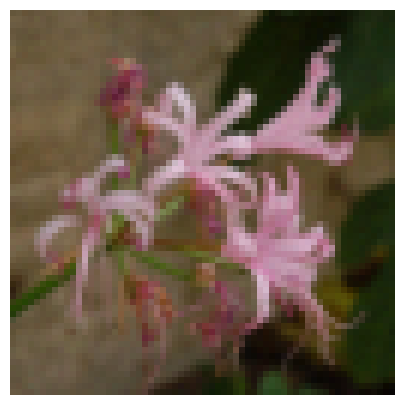

In [8]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')

images = next(iter(train_loader))[0]
image = images[0].float()

num_steps = 100
image_batch = image.unsqueeze(0).expand(num_steps, -1, -1, -1)
noise = torch.randn_like(image_batch)
timesteps = torch.linspace(0, T - 1, num_steps).round().long()

noisy_images = add_noise(image_batch, timesteps, noise, sqrt_alphas_bar, sqrt_one_minus_alphas_bar)
noisy_images = torch.clamp((noisy_images + 1) / 2, 0, 1)

def update(i):
    ax.imshow(np.transpose(noisy_images[i].numpy(), (1, 2, 0)))

ani = animation.FuncAnimation(fig, update, frames=num_steps, interval=50)
HTML(ani.to_jshtml())

## U-Net

![Example Image](unet.png)

In [9]:
class UpBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv_transpose = nn.ConvTranspose2d(out_channels, out_channels // 2, kernel_size=2, stride=2)

    def forward(self, X):
        X = self.double_conv(X)
        X = self.conv_transpose(X)

        return X

class DownBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.pool = nn.AvgPool2d(2)

    def forward(self, X):
        skip = self.double_conv(X)
        X = self.pool(skip)

        return X, skip
    

class UNet(nn.Module):
    
    def __init__(self, in_channels, out_channels, filters):
        super().__init__()

        self.downs = nn.ModuleList()

        for filter in filters:
            self.downs.append(DownBlock(in_channels, filter))
            in_channels = filter

        self.bottleneck = nn.Sequential(
            nn.Conv2d(filters[-1], filters[-1] * 2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(filters[-1] * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[-1] * 2, filters[-1] * 2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(filters[-1] * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(filters[-1] * 2, filters[-1], kernel_size=2, stride=2)
        )

        self.ups = nn.ModuleList()
        
        filters = filters[::-1]

        for filter in filters[:-1]:
            self.ups.append(UpBlock(filter * 2, filter))

        self.output_conv = nn.Conv2d(filters[-1], out_channels, kernel_size=1)

    def forward(self, X):
        skip_connections = []
        
        for down in self.downs:
            X, skip = down(X)
            skip_connections.append(skip)

        X = self.bottleneck(X)
        
        for up in self.ups:
            skip = skip_connections.pop()
            X = torch.cat([X, skip], dim=1)
            X = up(X)

        X = self.output_conv(X)
        
        return X

In [15]:
T = 1000
betas = linear_diffusion_schedule(timesteps=T)

alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, axis=0)
alphas_bar_prev = torch.cat([torch.tensor([1.0]), alphas_bar[:-1]])

sqrt_alphas_bar = torch.sqrt(alphas_bar)
sqrt_one_minus_alphas_bar = torch.sqrt(1.0 - alphas_bar)

q_variance =  ((1.0 - alphas_bar_prev) / (1.0 - alphas_bar)) * betas

In [16]:
unet = UNet(3, 3, [32, 64, 128]).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.MSELoss()
epochs = 5

In [17]:
for epoch in range(epochs):
    for i, (X, y) in enumerate(train_loader):
        batch_size = X.size(0)

        timesteps = torch.randint(0, T, (batch_size,)).long()
        noise = torch.randn_like(X)

        noisy_images = add_noise(X, timesteps, noise, sqrt_alphas_bar, sqrt_one_minus_alphas_bar)

        noise = noise.to(device)
        noisy_images = noisy_images.to(device)

        predicted_noise = unet(noisy_images)

        loss = criterion(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(f'Epoch {epoch} Iteration {i} Loss {loss.item()}')

Epoch 0 Iteration 0 Loss 1.031665563583374
Epoch 0 Iteration 50 Loss 0.8879899978637695
Epoch 0 Iteration 100 Loss 0.7799960970878601
Epoch 0 Iteration 150 Loss 0.7046680450439453
Epoch 0 Iteration 200 Loss 0.6795048713684082
Epoch 1 Iteration 0 Loss 0.6533593535423279
Epoch 1 Iteration 50 Loss 0.6138699054718018
Epoch 1 Iteration 100 Loss 0.5849626064300537
Epoch 1 Iteration 150 Loss 0.5483181476593018
Epoch 1 Iteration 200 Loss 0.5691448450088501
Epoch 2 Iteration 0 Loss 0.5500875115394592
Epoch 2 Iteration 50 Loss 0.5210771560668945
Epoch 2 Iteration 100 Loss 0.4958764910697937
Epoch 2 Iteration 150 Loss 0.4772767722606659
Epoch 2 Iteration 200 Loss 0.4646798372268677
Epoch 3 Iteration 0 Loss 0.4842838943004608
Epoch 3 Iteration 50 Loss 0.4570840299129486
Epoch 3 Iteration 100 Loss 0.4556923806667328
Epoch 3 Iteration 150 Loss 0.45524531602859497
Epoch 3 Iteration 200 Loss 0.4270192086696625
Epoch 4 Iteration 0 Loss 0.4381454885005951
Epoch 4 Iteration 50 Loss 0.4168105721473694
Epo

  0%|          | 0/999 [00:00<?, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


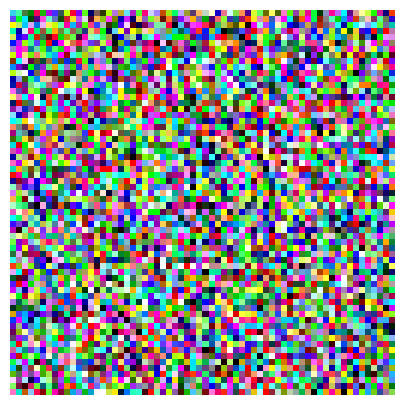

In [19]:
unet.eval()
sample = torch.randn(1, 3, 64, 64).to(device)

samples = []

for t in tqdm(range(T - 1, 0, -1)):
    z = torch.randn(1, 3, 64, 64).to(device)

    beta = betas[t]

    sqrt_alpha_bar = sqrt_alphas_bar[t]
    sqrt_one_minus_alpha_bar = sqrt_one_minus_alphas_bar[t]

    sample = (1 / (alphas[t]**(1/2))) * (sample - ((1 - alphas[t]) / (sqrt_one_minus_alpha_bar)) * unet(sample)) + z * (q_variance[t] ** (1/2))
    samples.append(sample)
    
    break

# Plot the denoised image
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')
ax.imshow(np.transpose((sample[0].cpu().detach().numpy() + 1) / 2, (1, 2, 0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Noise')

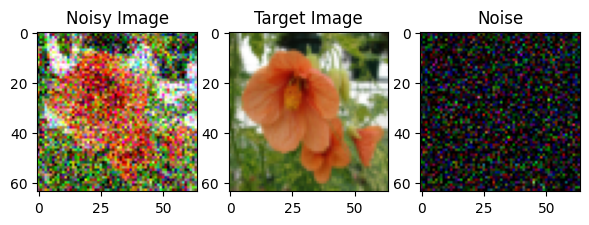

In [14]:
target1 = target[0]

X_1 = target1 + torch.randn_like(target1) * 0.25

# plot the noisy image, the target image and the noise level
noise = X_1 - target1

fig, axes = plt.subplots(figsize=(7, 7), nrows=1, ncols=3)
axes[0].imshow(np.transpose(X_1.cpu().numpy(), (1, 2, 0)))
axes[0].set_title('Noisy Image')
axes[1].imshow(np.transpose(target1.cpu().numpy(), (1, 2, 0)))
axes[1].set_title('Target Image')
axes[2].imshow(np.transpose(noise.cpu().numpy(), (1, 2, 0)))
axes[2].set_title('Noise')